## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
from typing import Tuple, List, Type, Dict, Any
from tqdm.notebook import tqdm

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [5]:
train_set, val_set = torch.utils.data.random_split(fmnist_dataset_train, [50000, 10000])

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [32]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        
    def __call__(self, inp):
        return self.forward(inp)

In [33]:

torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 204,042
Trainable params: 204,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


In [34]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
print(model)

TinyNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [35]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [36]:
def train_model(
        model: torch.nn.Module,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
        optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
        optimizer_params: Dict = {},
        initial_lr=0.01,
        lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_params: Dict = {},
        batch_size=128,
        max_epochs=1000,
        early_stopping_patience=20):
    optimizer = optimizer_class(model.parameters(),
                                 lr=initial_lr,
                                 **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)

    best_val_loss = None
    best_epoch = None
    val_loss_array = []
    train_loss_array = []
    val_accuracy_array = []

    for epoch in range(max_epochs):
        print(f'Epoch {epoch}')
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)

        train_loss_array.append(train_loss)
        val_loss_array.append(val_metrics['loss'])
        val_accuracy_array.append(val_metrics['accuracy'])

        print(f'Validation metrics: \n{val_metrics}')
        print(f'Train metrics: \n loss: {train_loss}')

        lr_scheduler.step(val_metrics['loss'])

        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')

        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return
    
    return train_loss_array, val_loss_array, val_accuracy_array

In [37]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       data_loader: torch.utils.data.DataLoader):
    model.train()
    loss_sum = 0
    batches = 0
    for x_batch, y_batch in data_loader:
        batches += 1
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch.to(device))
        loss_sum += loss
        loss.backward()
        optimizer.step()
    return loss_sum / batches

In [38]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    loss_history = []
    accuracy_history = []
    acc = 0
    batches = 0
    loss = 0
    for x_batch, y_batch in data_loader:
        batches += 1
        x_batch = x_batch.to(device)
        with torch.no_grad():
            y_pred = model(x_batch)
        loss += loss_function(y_pred, y_batch.to(device)).item()
        acc += (torch.argmax(y_pred, dim=1) == y_batch.to(device)).cpu().numpy().mean()

    return {'loss': loss / batches, 'accuracy': acc / batches}

In [39]:
train_loss_array, val_loss_array, val_accuracy_array = train_model(model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=torch.nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adam,
            initial_lr=0.001,
            max_epochs=15)

Epoch 0
Validation metrics: 
{'loss': 0.4043301515564134, 'accuracy': 0.8559137658227848}
Train metrics: 
 loss: 0.53608238697052
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.37835777975335905, 'accuracy': 0.8615506329113924}
Train metrics: 
 loss: 0.41608762741088867
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.3693551311764536, 'accuracy': 0.8667919303797469}
Train metrics: 
 loss: 0.38759517669677734
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.35567914439907555, 'accuracy': 0.8668908227848101}
Train metrics: 
 loss: 0.3641393184661865
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.3473130964402911, 'accuracy': 0.8721321202531646}
Train metrics: 
 loss: 0.34758737683296204
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.3401982639032074, 'accuracy': 0.8770767405063291}
Train metrics: 
 loss: 0.33951324224472046
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.32793226291107225, 'accura

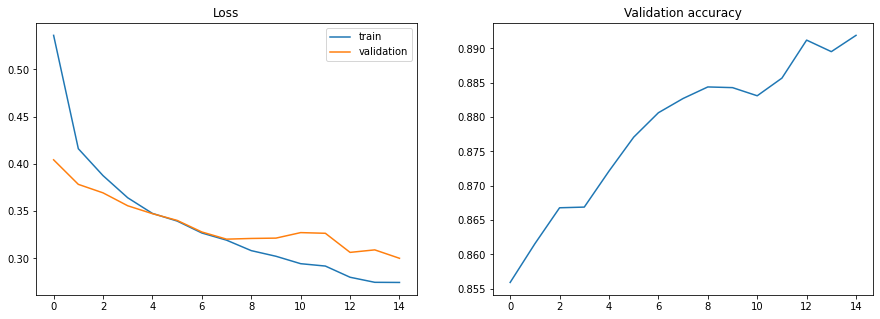

In [40]:
plot_train_process(train_loss_array, val_loss_array, val_accuracy_array)

In [41]:
def test_predict(test_loader):
    model = torch.load('./best_model.pth')
    model.eval()

    acc = 0
    batches = 0
    for x_batch, y_batch in test_loader:
        y_pred = model.forward(x_batch.to(device))
        batches += 1
        acc += ((torch.argmax(y_pred, dim=1) == y_batch.to(device)).cpu().numpy().mean())
    return (acc/batches)

In [42]:
print(test_predict(test_loader=test_loader))

0.88779296875


Your experiments come here:

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
    def __call__(self, inp):
        return self.forward(inp)

In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


In [22]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

print(model)
# Your experiments, come here

OverfittingNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [23]:
train_loss_array, val_loss_array, val_accuracy_array = train_model(model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=torch.nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adam,
            initial_lr=0.001,
            max_epochs=20)

Epoch 0
Validation metrics: 
{'loss': 0.45269613590421554, 'accuracy': 0.8358386075949367}
Train metrics: 
 loss: 0.5493765473365784
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.37175372780501087, 'accuracy': 0.8653085443037974}
Train metrics: 
 loss: 0.37706074118614197
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.36615640057038656, 'accuracy': 0.8616495253164557}
Train metrics: 
 loss: 0.33989739418029785
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.35322053145758714, 'accuracy': 0.867879746835443}
Train metrics: 
 loss: 0.31102776527404785
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.35064457753036593, 'accuracy': 0.8752966772151899}
Train metrics: 
 loss: 0.29118525981903076
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.3201251546793346, 'accuracy': 0.883504746835443}
Train metrics: 
 loss: 0.2768471837043762
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.3138001764876933, 'accu

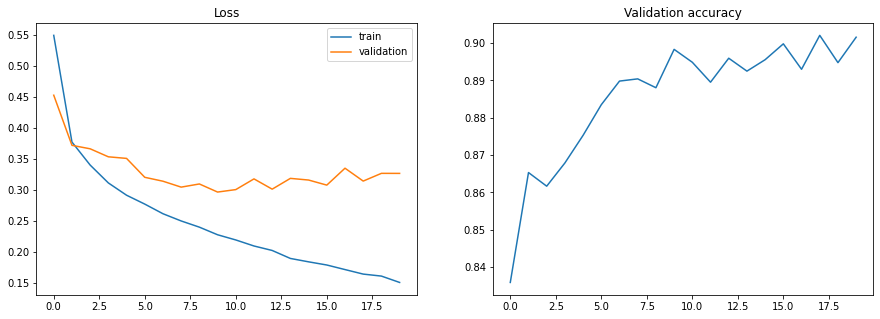

In [24]:
plot_train_process(train_loss_array, val_loss_array, val_accuracy_array)

In [25]:
print(test_predict(test_loader=test_loader))

0.89375


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [26]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256,),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
    def __call__(self, inp):
        return self.forward(inp)

In [27]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.05
Estimated T

In [28]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

print(model)
# Your experiments, come here

FixedNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [29]:
train_loss_array, val_loss_array, val_accuracy_array = train_model(model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_function=torch.nn.functional.cross_entropy,
            optimizer_class=torch.optim.Adam,
            initial_lr=0.001,
            max_epochs=20)

Epoch 0
Validation metrics: 
{'loss': 0.42395844678335554, 'accuracy': 0.8475079113924051}
Train metrics: 
 loss: 0.5612640976905823
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.3698777164085002, 'accuracy': 0.8630340189873418}
Train metrics: 
 loss: 0.42829403281211853
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.3831068341490589, 'accuracy': 0.8580893987341772}
Train metrics: 
 loss: 0.39338910579681396
Epoch 3
Validation metrics: 
{'loss': 0.3403741219375707, 'accuracy': 0.8763844936708861}
Train metrics: 
 loss: 0.3705461919307709
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.33669773479805715, 'accuracy': 0.8768789556962026}
Train metrics: 
 loss: 0.35381731390953064
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.31173209280152864, 'accuracy': 0.8872626582278481}
Train metrics: 
 loss: 0.3401275873184204
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.3173494255995449, 'accuracy': 0.882021360759493

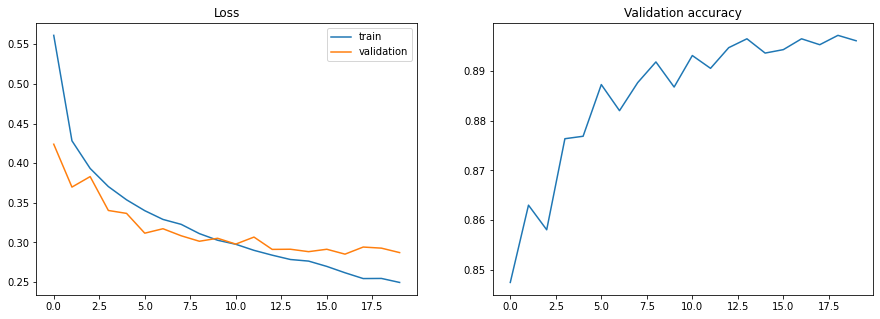

In [30]:
plot_train_process(train_loss_array, val_loss_array, val_accuracy_array)

In [31]:
print(test_predict(test_loader=test_loader))

0.887109375


### Conclusions:
_Write down small report with your conclusions and your ideas._

* As expected, the perceptron without regularization techniques retrained. We see that the loss on the train continues to fall, and on validation begins to grow upwards. Also accuracy on validation stops increasing and starts bouncing up and down. So, as we can see from the learning process, we saved the best model at epoch 9. The best model gives 89.375% accuracy on the test.
* As we can see, adding batchnorm and dropout has improved the situation with overfitting, the loss on train and validation decrease together. Also adding dropout expectedly decreased accuracy on the test (the best model gives 88.71%), because the complexity of the model drops with the addition of dropout. We can also see that the batchnorm has a positive effect on the convergence.